In [0]:
# imports 
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd


In [0]:

# Physical Properties and Literature Values
ethanol_density = 789 #kg/m3
water_density = 1000 # kg/m3
OG = 1.048 # [Ranges from 1.035 to 1.060] (wort original gravity)
yeast_pitch_rate = 0.75 # million cells/mL/degP, typical value for ales
yeast_density = 40e-12 # g/cell [typically 15 to 40 pg/cell for saccharomyces cerevisiae]


In [0]:
#input parameters
volume = 1200 # L (from 30 L baseline), wort volume rather than vessel volume
duration = 336 # hr, duration of fermentation in hours (og = 336)
temperature = 19 # degC

#Parameters from Table 5
k_s = 15.3 #in gS/gX (sugar yield coefficient) 
k_e = 6.31 #in gE/gX (ethanol yield coefficient)
S_min = 13.1 # in g/L (minimum sugar quota)
g_x = 0.0167 # in hr-1 (aka delta_x), settling/dealth constant
k_v = 0.651 # in gVDK/gX (VDK yield coefficient)
k_co2 = 3.71 # in L (CO2 yield coefficient) - changed from 37.1
a = 0.4 # in h-1 (temperature coefficient mu_max)
b = -1.1 # in h-1 (temperature coefficient mu_max)
c = 0.025 # in h-1 (temperature coefficient r_vdk)
d = -0.056 #in h-1



In [0]:


#Calculations:

#Sugar Concentration: Convert OG to Deg Plato 
#Degrees Plato measure conc. of dissolved solids, 1 deg P = 1g of sugar/extract per 100 g of wort
degP = (-1 * 616.868) + (1111.14 * OG) - (630.272 * OG**2) + (135.997 * OG**3)
wort_density = OG * water_density
s_calc = (degP/100) * wort_density
print("The initial sugar concentration is", s_calc, "g/L")

#Yeast Concentration: 
yeast_req = yeast_pitch_rate * (volume * 1000) * degP * 10**6 # cells
mass_yeast = yeast_req * yeast_density  # in g
yeast_conc = mass_yeast / volume #in g/L
print("The initial biomass concentration is", yeast_conc ,"g/L")

# Initial conditions
x0 = yeast_conc # initial biomass in g/L
s0 = s_calc # initial sugar concentration in g/L
e0 = 0 # initial ethanol concentration in g/L
co2_0 = 0 # initial carbon dioxide in L
vdk_0 = 0 # initial VDK (ppm)

#Calculate temperature dependent parameters, assume isothermal fermentation due to presence of cooling jacket
#Temperature to be in Kelvin for mu_max calculation
temp_kelvin = temperature + 273.15
mu_max = a * np.log(temperature) + b
#mu_max = 0.15 #hr-1 taken from Lip, Rios and Costa
print("The mu_max =", mu_max)
r_vdk = c * np.log(temperature) + d
print("The r_vdk = ", r_vdk)

initial_conditions = [x0, s0, e0, co2_0, vdk_0]

# Simulation parameters
time_points = np.linspace(0, duration, 1000)


The initial sugar concentration is 124.83860632522737 g/L
The initial biomass concentration is 0.3573624226867196 g/L
The mu_max = 0.0777755916665761
The r_vdk =  0.01761097447916101


In [0]:
#Calculation functions

# A function to calculate the biomass specific growth rate (Eq. 27) where Monod law is replaced by Droop-like factor
def mu_x(s, S_min, mu_max):
    if s >= S_min:
        return mu_max * (1-(S_min/s))
    else:
        return 0

# A function to define ODEs for beer fermentation (Eq 26a-26e)
def ODE(t, state):
    x, s, e, co2, vdk = state

    mu = max(0, mu_x(s, S_min, mu_max))

    dx_dt = (mu * x) - (g_x * x) # net live biomass at time t, viable yeast only

    ds_dt = -k_s * mu * x


    #if s <= S_min:
     #   ds_dt = 0
    #    mu = 0
    #else:
     #   ds_dt = -k_s * mu * x

    de_dt = k_e * mu * x
    dco2_dt = k_co2 * mu * x 
    dvdk_dt = k_v * mu * x - r_vdk * vdk

    return dx_dt, ds_dt, de_dt, dco2_dt, dvdk_dt

solution = solve_ivp(
    ODE,
    t_span=(0, duration),
    y0=initial_conditions,
    t_eval=time_points
)


In [0]:
t = solution.t

x_result   = solution.y[0] # g of biomass / L of wort
s_result   = solution.y[1] # g sugar / L wort
e_result   = solution.y[2] # g ethanol / L wort
co2_result = solution.y[3] # L co2/ L wort
vdk_result = solution.y[4] 

abv_result = (e_result / ethanol_density) * 100
ppb_result = vdk_result * 1000


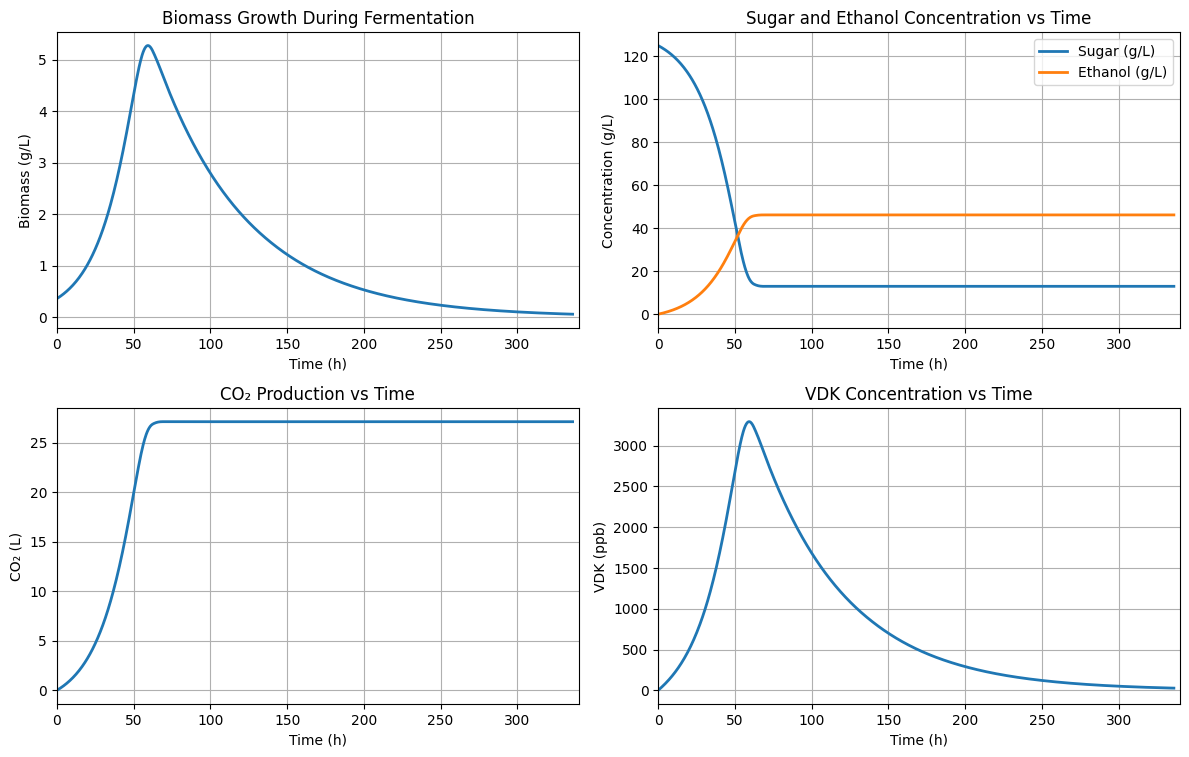

Final VDK concentration: 26.55 ppb
Final ABV: 5.85 
Final Ethanol: 46.14 g of ethanol / L wort
Final sugar: 12.96 g/L of wort
Final co2: 27.13 L per L of wort
Final biomass: 0.05 g per L of wort
132.1509614005946


In [0]:
fig, axs = plt.subplots(3, 2, figsize=(12, 11))
axs = axs.flatten()

# Biomass
axs[0].plot(t, x_result, linewidth=2)
axs[0].set_title("Biomass Growth During Fermentation")
axs[0].set_ylabel("Biomass (g/L)")
axs[0].set_xlim(0, 340)

# Sugar + Ethanol (g/L) COMBINED
axs[1].plot(t, s_result, linewidth=2, label="Sugar (g/L)")
axs[1].plot(t, e_result, linewidth=2, label="Ethanol (g/L)")
axs[1].set_title("Sugar and Ethanol Concentration vs Time")
axs[1].set_ylabel("Concentration (g/L)")
axs[1].set_xlim(0, 340)
axs[1].legend()

# CO2
axs[2].plot(t, co2_result, linewidth=2)
axs[2].set_title("CO₂ Production vs Time")
axs[2].set_ylabel("CO₂ (L)")
axs[2].set_xlim(0, 340)

# VDK
axs[3].plot(t, ppb_result, linewidth=2)
axs[3].set_title("VDK Concentration vs Time")
axs[3].set_ylabel("VDK (ppb)")
axs[3].set_xlim(0, 340)

# Remove unused subplots
fig.delaxes(axs[4])
fig.delaxes(axs[5])

for ax in axs[:4]:
    ax.set_xlabel("Time (h)")
    ax.grid(True)

plt.tight_layout()
plt.show()


#Final Values
final_vdk_ppb = ppb_result[-1]
print(f"Final VDK concentration: {final_vdk_ppb:.2f} ppb")

final_abv = abv_result[-1]
print(f"Final ABV: {final_abv:.2f} ")

final_e = e_result[-1]
print(f"Final Ethanol: {final_e:.2f} g of ethanol / L wort")

final_s = s_result[-1]
print(f"Final sugar: {final_s:.2f} g/L of wort")

final_co2 = co2_result[-1]
print(f"Final co2: {final_co2:.2f} L per L of wort")

final_x = x_result[-1]
print(f"Final biomass: {final_x:.2f} g per L of wort")

total_biomass_produced = s0 + ((s0 - final_s)/k_s)
print(total_biomass_produced)


In [0]:
# ===============================
# SENSITIVITY ANALYSIS (4 cases)
# ===============================

print("\n--- Sensitivity Analysis (±20% Sugar, ±2°C) ---")

sugar_delta = 0.20
temp_delta = 2

scenarios = {
    "(+20% S, +2C)": (s_calc * (1 + sugar_delta), temperature + temp_delta),
    "(+20% S, -2C)": (s_calc * (1 + sugar_delta), temperature - temp_delta),
    "(-20% S, +2C)": (s_calc * (1 - sugar_delta), temperature + temp_delta),
    "(-20% S, -2C)": (s_calc * (1 - sugar_delta), temperature - temp_delta),
}

ethanol_profiles = {}
sugar_profiles = {}
biomass_profiles = {}
co2_profiles = {}
vdk_profiles = {}

for name, (s_init, temp_case) in scenarios.items():

    # Temperature-dependent parameter recalculation
    r_vdk_case = c * np.log(temp_case) + d

    # Initial conditions
    initial_conditions_case = [x0, s_init, 0, 0, 0]

    # ODE system for this scenario
    def ODE_case(t, state):
        x, s, e, co2, vdk = state

        mu = max(0, mu_x(s, S_min, mu_max))

        dx_dt = (mu * x) - (g_x * x)
        ds_dt = -k_s * mu * x
        de_dt = k_e * mu * x
        dco2_dt = k_co2 * mu * x
        dvdk_dt = k_v * mu * x - r_vdk_case * vdk

        return dx_dt, ds_dt, de_dt, dco2_dt, dvdk_dt

    solution_case = solve_ivp(
        ODE_case,
        t_span=(0, duration),
        y0=initial_conditions_case,
        t_eval=time_points
    )

    x_case = solution_case.y[0]
    s_case = solution_case.y[1]
    e_case = solution_case.y[2]
    co2_case = solution_case.y[3]
    vdk_case = solution_case.y[4]

    ethanol_profiles[name] = e_case
    sugar_profiles[name] = s_case
    biomass_profiles[name] = x_case
    co2_profiles[name] = co2_case
    vdk_profiles[name] = vdk_case * 1000  # convert to ppb

    # Print final outputs
    print(f"\nScenario {name}")
    print(f"Final Ethanol: {e_case[-1]:.2f} g/L")
    print(f"Final Sugar: {s_case[-1]:.2f} g/L")
    print(f"Final Biomass: {x_case[-1]:.2f} g/L")
    print(f"Final CO2: {co2_case[-1]:.2f} L/L")
    print(f"Final VDK: {(vdk_case[-1]*1000):.2f} ppb")



--- Sensitivity Analysis (±20% Sugar, ±2°C) ---

Scenario (+20% S, +2C)
Final Ethanol: 56.52 g/L
Final Sugar: 12.75 g/L
Final Biomass: 0.07 g/L
Final CO2: 33.23 L/L
Final VDK: 16.29 ppb

Scenario (+20% S, -2C)
Final Ethanol: 58.11 g/L
Final Sugar: 8.92 g/L
Final Biomass: 0.07 g/L
Final CO2: 34.16 L/L
Final VDK: 78.29 ppb

Scenario (-20% S, +2C)
Final Ethanol: 35.79 g/L
Final Sugar: 13.10 g/L
Final Biomass: 0.04 g/L
Final CO2: 21.04 L/L
Final VDK: 9.49 ppb

Scenario (-20% S, -2C)
Final Ethanol: 35.79 g/L
Final Sugar: 13.10 g/L
Final Biomass: 0.04 g/L
Final CO2: 21.04 L/L
Final VDK: 44.99 ppb


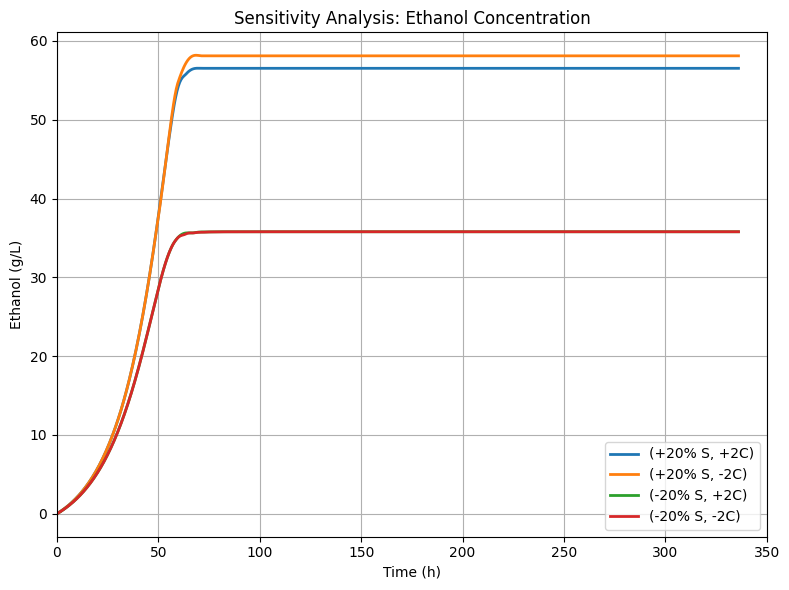

In [0]:
plt.figure(figsize=(8,6))

for name, profile in ethanol_profiles.items():
    plt.plot(t, profile, linewidth=2, label=name)

plt.title("Sensitivity Analysis: Ethanol Concentration")
plt.xlabel("Time (h)")
plt.ylabel("Ethanol (g/L)")
plt.xlim(0, 350)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


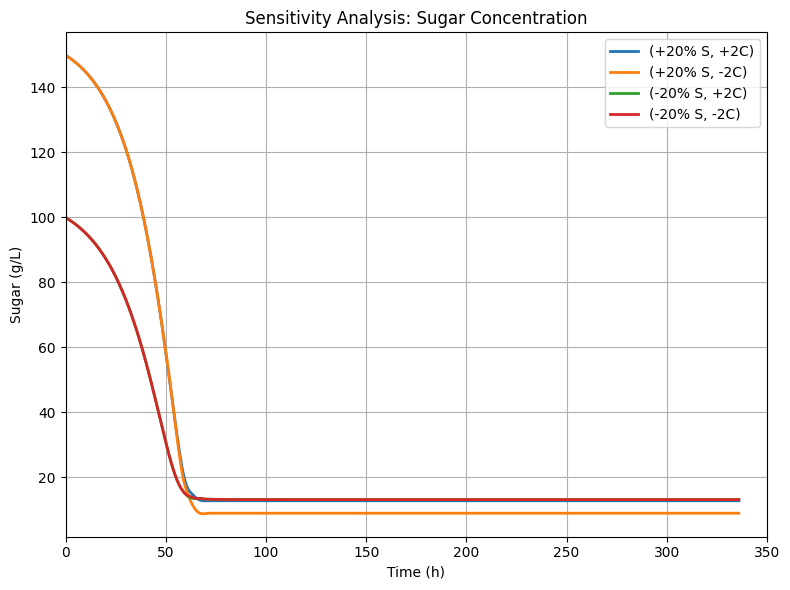

In [0]:
plt.figure(figsize=(8,6))
for name, profile in sugar_profiles.items():
    plt.plot(t, profile, linewidth=2, label=name)

plt.title("Sensitivity Analysis: Sugar Concentration")
plt.xlabel("Time (h)")
plt.ylabel("Sugar (g/L)")
plt.xlim(0, 350)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


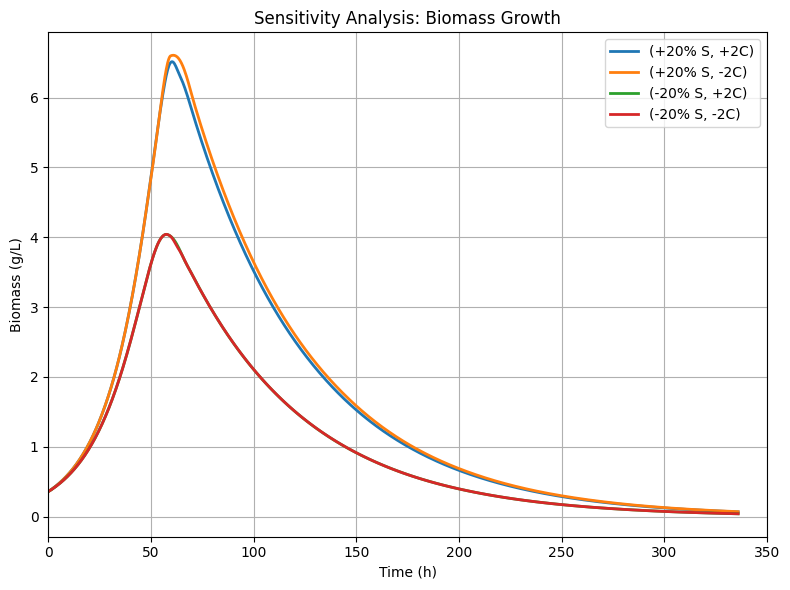

In [0]:
plt.figure(figsize=(8,6))
for name, profile in biomass_profiles.items():
    plt.plot(t, profile, linewidth=2, label=name)

plt.title("Sensitivity Analysis: Biomass Growth")
plt.xlabel("Time (h)")
plt.ylabel("Biomass (g/L)")
plt.xlim(0, 350)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


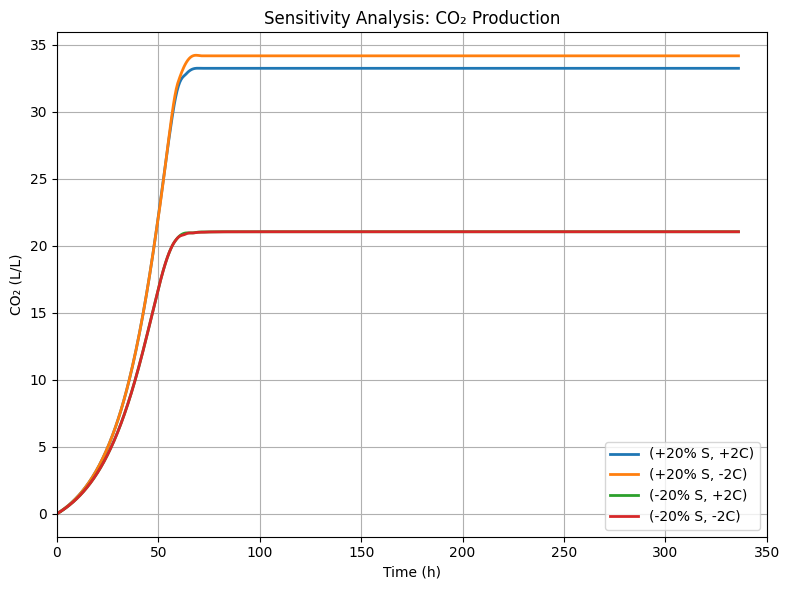

In [0]:
plt.figure(figsize=(8,6))
for name, profile in co2_profiles.items():
    plt.plot(t, profile, linewidth=2, label=name)

plt.title("Sensitivity Analysis: CO₂ Production")
plt.xlabel("Time (h)")
plt.ylabel("CO₂ (L/L)")
plt.xlim(0, 350)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


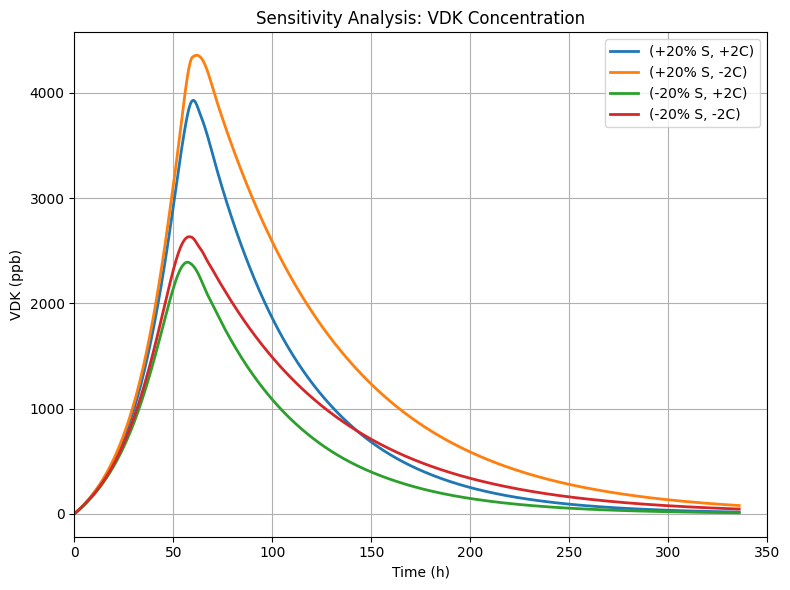

In [0]:
plt.figure(figsize=(8,6))
for name, profile in vdk_profiles.items():
    plt.plot(t, profile, linewidth=2, label=name)

plt.title("Sensitivity Analysis: VDK Concentration")
plt.xlabel("Time (h)")
plt.ylabel("VDK (ppb)")
plt.xlim(0, 350)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
